In [1]:
print("hello")

hello


In [4]:
!pip install torch torchvision matplotlib numpy opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [3]:
class ShapeDataset(Dataset):
    def __init__(self, num_samples=1000, img_size=28):
        self.img_size = img_size
        self.num_samples = num_samples
        self.shapes = ['circle', 'square', 'triangle']
        self.data = []
        self.labels = []
        self._generate_dataset()

    def _generate_shape(self, shape):
        img = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
        if shape == "circle":
            cv2.circle(img, (14, 14), 7, 255, -1)
        elif shape == "square":
            cv2.rectangle(img, (7, 7), (21, 21), 255, -1)
        elif shape == "triangle":
            pts = np.array([[14, 6], [6, 22], [22, 22]], np.int32)
            cv2.drawContours(img, [pts], 0, 255, -1)
        return img

    def _generate_dataset(self):
        for _ in range(self.num_samples):
            shape = random.choice(self.shapes)
            img = self._generate_shape(shape)
            label = self.shapes.index(shape)
            self.data.append(img)
            self.labels.append(label)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = self.data[idx]
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).view(-1)
        label = torch.tensor(self.labels[idx])
        return img, label


In [4]:
def one_hot(labels, num_classes=3):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()


In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=3, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, img_dim=784, label_dim=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat([img, labels], dim=1)
        return self.model(x)


In [6]:
# Hyperparameters
epochs = 100
batch_size = 64
noise_dim = 100
lr = 0.0002

# Data
dataset = ShapeDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Models
generator = Generator(noise_dim=noise_dim)
discriminator = Discriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training Loop
for epoch in range(epochs):
    for real_imgs, labels in dataloader:
        batch_size = real_imgs.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # One-hot encode labels
        labels_onehot = one_hot(labels)

        # Train Discriminator
        z = torch.randn(batch_size, noise_dim)
        fake_imgs = generator(z, labels_onehot).detach()

        d_real = discriminator(real_imgs, labels_onehot)
        d_fake = discriminator(fake_imgs, labels_onehot)

        d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim)
        fake_imgs = generator(z, labels_onehot)
        d_fake = discriminator(fake_imgs, labels_onehot)
        g_loss = criterion(d_fake, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")


Epoch [10/100] D_loss: 1.0205 G_loss: 0.7795
Epoch [20/100] D_loss: 0.5236 G_loss: 1.5170
Epoch [30/100] D_loss: 0.6590 G_loss: 1.1509
Epoch [40/100] D_loss: 1.1093 G_loss: 0.7199
Epoch [50/100] D_loss: 0.8369 G_loss: 1.0521
Epoch [60/100] D_loss: 0.8204 G_loss: 1.1396
Epoch [70/100] D_loss: 0.8846 G_loss: 0.9703
Epoch [80/100] D_loss: 0.8517 G_loss: 1.0540
Epoch [90/100] D_loss: 0.5439 G_loss: 1.4744
Epoch [100/100] D_loss: 0.6320 G_loss: 1.3770


In [ ]:
def generate_and_plot(label_text):
    label_dict = {'circle': 0, 'square': 1, 'triangle': 2}
    label = torch.tensor([label_dict[label_text]])
    label_onehot = one_hot(label)
    noise = torch.randn(1, noise_dim)
    with torch.no_grad():
        fake_img = generator(noise, label_onehot).view(28, 28)
    plt.imshow(fake_img.cpu(), cmap='gray')
    plt.title(f'Generated: {label_text}')
    plt.axis('off')
    plt.show()

generate_and_plot("circle")
generate_and_plot("square")
generate_and_plot("triangle")


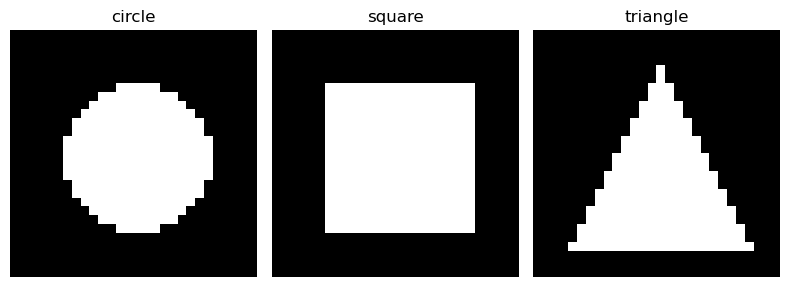

In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

def draw_shape(label, size=(28, 28)):
    img = Image.new('L', size, color=0)
    draw = ImageDraw.Draw(img)
    if label == "circle":
        draw.ellipse((6, 6, 22, 22), fill=255)
    elif label == "square":
        draw.rectangle((6, 6, 22, 22), fill=255)
    elif label == "triangle":
        draw.polygon([(14, 4), (4, 24), (24, 24)], fill=255)
    return img

# Just draw and display one of each shape (no saving to files)
labels = ['circle', 'square', 'triangle']
images = [draw_shape(label) for label in labels]

# Display safely
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for ax, img, label in zip(axes, images, labels):
    ax.imshow(np.array(img), cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()
